# Heart Failure Prediction - Model Training and Comparison

This notebook builds and compares 4 machine learning models:
1. Logistic Regression (baseline)
2. Random Forest (with hyperparameter tuning)
3. XGBoost (with hyperparameter tuning)
4. LightGBM (with hyperparameter tuning)

Each model is evaluated using:
- ROC-AUC score
- Confusion matrix
- Classification report
- Feature importance


## 1. Import Libraries


In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Machine Learning - Evaluation
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)

# Model persistence
import joblib
import os
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✓ All libraries imported successfully!
Timestamp: 2025-12-04 14:03:17


## 2. Load Prepared Data


In [2]:
# Load the original dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Separate features and target
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Perform train-test split (same as in EDA notebook)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Load the scaler and scale the data
scaler = joblib.load('models/scaler.pkl')
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Data Loaded Successfully:")
print("=" * 60)
print(f"Training samples: {len(X_train_scaled)}")
print(f"Test samples: {len(X_test_scaled)}")
print(f"Number of features: {X_train_scaled.shape[1]}")
print(f"\nFeatures: {list(X.columns)}")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts())
print(f"\n✓ Data ready for model training!")


Data Loaded Successfully:
Training samples: 239
Test samples: 60
Number of features: 12

Features: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']

Target distribution in training set:
DEATH_EVENT
0    162
1     77
Name: count, dtype: int64

✓ Data ready for model training!


## 3. Helper Functions for Model Evaluation


In [3]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive model evaluation function.
    
    Parameters:
    -----------
    model : sklearn-like model
        Trained model to evaluate
    X_train, X_test : array-like
        Training and test features
    y_train, y_test : array-like
        Training and test labels
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary containing all evaluation metrics
    """
    print(f"\n{'='*70}")
    print(f"{model_name.upper()} - EVALUATION RESULTS")
    print(f"{'='*70}\n")
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Prediction probabilities for ROC-AUC
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'roc_auc': roc_auc_score(y_train, y_train_proba)
    }
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba)
    }
    
    # Print metrics comparison
    print("1. PERFORMANCE METRICS:")
    print("-" * 70)
    print(f"{'Metric':<20} {'Training':<20} {'Test':<20}")
    print("-" * 70)
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        print(f"{metric.upper():<20} {train_metrics[metric]:<20.4f} {test_metrics[metric]:<20.4f}")
    print("-" * 70)
    
    # Confusion Matrix
    print("\n2. CONFUSION MATRIX (Test Set):")
    print("-" * 70)
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)
    print(f"\nTrue Negatives: {cm[0,0]}")
    print(f"False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}")
    print(f"True Positives: {cm[1,1]}")
    
    # Classification Report
    print("\n3. CLASSIFICATION REPORT (Test Set):")
    print("-" * 70)
    print(classification_report(y_test, y_test_pred, target_names=['Survived', 'Died']))
    
    return {
        'model_name': model_name,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'confusion_matrix': cm,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba
    }

def plot_confusion_matrix(cm, model_name):
    """
    Plot confusion matrix heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'],
                annot_kws={'size': 16, 'fontweight': 'bold'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Actual', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_test, y_test_proba, model_name):
    """
    Plot ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, model_name, top_n=15):
    """
    Plot feature importance for tree-based models.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"No feature importance available for {model_name}")
        return
    
    # Create DataFrame
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_imp)), feature_imp['importance'], color='steelblue', edgecolor='black')
    plt.yticks(range(len(feature_imp)), feature_imp['feature'])
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return feature_imp

print(" Helper functions defined successfully!")


 Helper functions defined successfully!


In [4]:
print("MODEL 1: LOGISTIC REGRESSION (BASELINE)")

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print("\n Model trained successfully!")
print(f"Model parameters: {lr_model.get_params()}")


MODEL 1: LOGISTIC REGRESSION (BASELINE)

 Model trained successfully!
Model parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [5]:
# Evaluate Logistic Regression
lr_results = evaluate_model(lr_model, X_train_scaled, X_test_scaled, 
                            y_train, y_test, "Logistic Regression")



LOGISTIC REGRESSION - EVALUATION RESULTS

1. PERFORMANCE METRICS:
----------------------------------------------------------------------
Metric               Training             Test                
----------------------------------------------------------------------
ACCURACY             0.8536               0.8167              
PRECISION            0.8000               0.7857              
RECALL               0.7273               0.5789              
F1                   0.7619               0.6667              
ROC_AUC              0.9052               0.8588              
----------------------------------------------------------------------

2. CONFUSION MATRIX (Test Set):
----------------------------------------------------------------------
[[38  3]
 [ 8 11]]

True Negatives: 38
False Positives: 3
False Negatives: 8
True Positives: 11

3. CLASSIFICATION REPORT (Test Set):
----------------------------------------------------------------------
              precision    recall

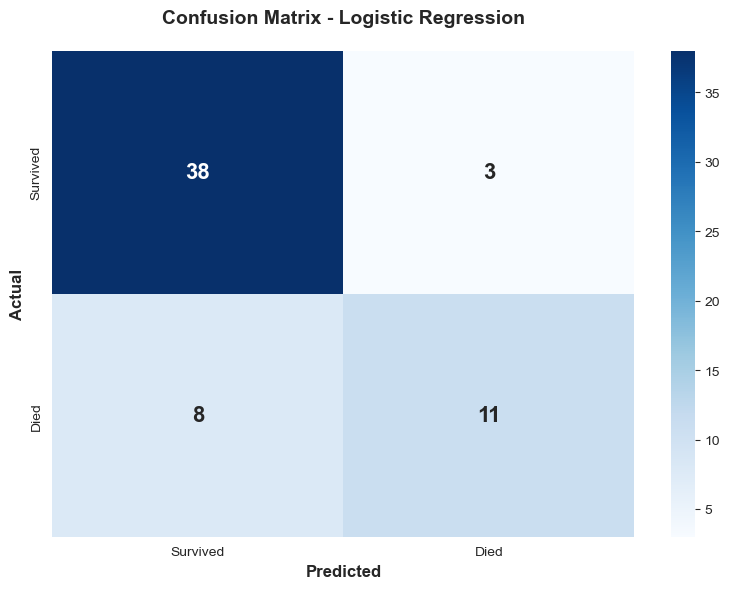

In [6]:
# Visualizations for Logistic Regression
plot_confusion_matrix(lr_results['confusion_matrix'], "Logistic Regression")


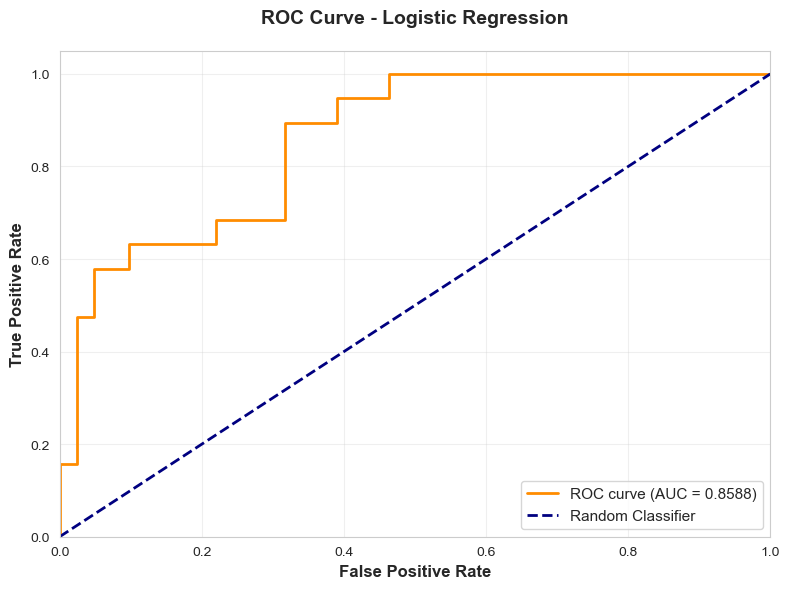

In [7]:
plot_roc_curve(y_test, lr_results['y_test_proba'], "Logistic Regression")


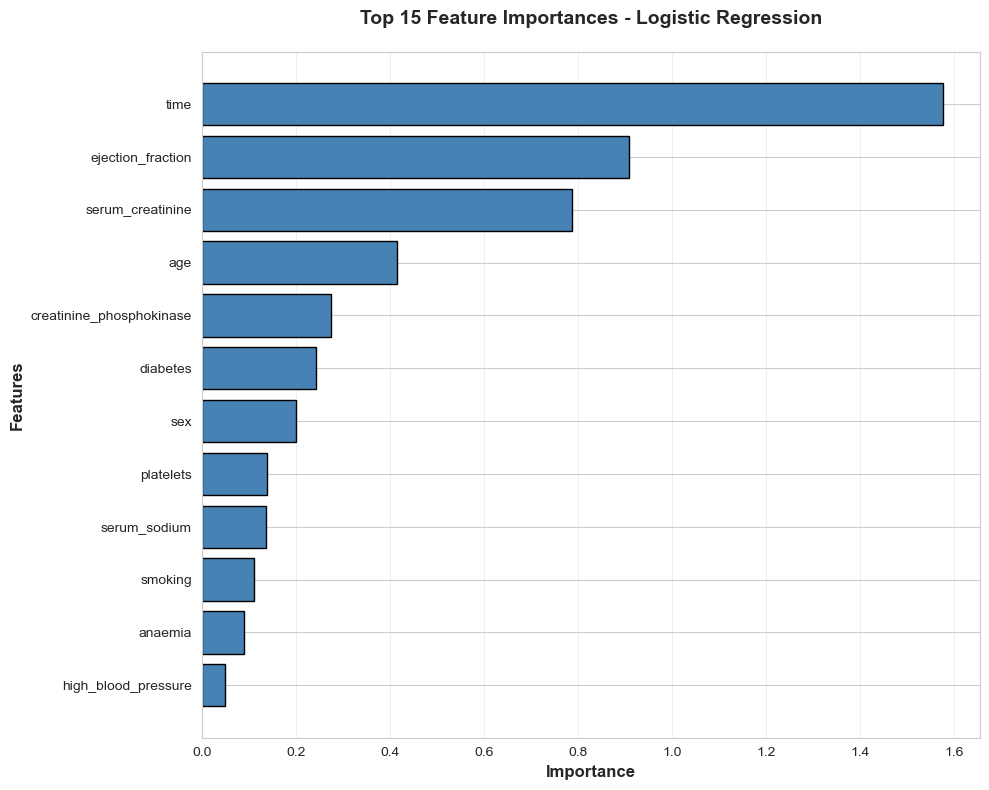


Top 10 Most Important Features:
                     feature  importance
11                      time    1.577011
4          ejection_fraction    0.909601
7           serum_creatinine    0.787676
0                        age    0.416343
2   creatinine_phosphokinase    0.275913
3                   diabetes    0.242201
9                        sex    0.200936
6                  platelets    0.139808
8               serum_sodium    0.137449
10                   smoking    0.111317


In [8]:
# Feature importance (coefficients)
lr_feature_imp = plot_feature_importance(lr_model, X.columns, "Logistic Regression")
print("\nTop 10 Most Important Features:")
print(lr_feature_imp.head(10))


In [9]:
print("MODEL 2: RANDOM FOREST (WITH HYPERPARAMETER TUNING)")

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

# Initialize Random Forest
rf_base = RandomForestClassifier(random_state=42)

# GridSearchCV with cross-validation
print("\nStarting GridSearchCV")
print(f"Testing {len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf']) * len(rf_param_grid['max_features']) * len(rf_param_grid['class_weight'])} combinations")

rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train_scaled, y_train)

print("\n GridSearchCV completed!")
print(f"\nBest parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {rf_grid_search.best_score_:.4f}")

# Best model
rf_model = rf_grid_search.best_estimator_


MODEL 2: RANDOM FOREST (WITH HYPERPARAMETER TUNING)

Starting GridSearchCV
Testing 432 combinations
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 GridSearchCV completed!

Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation ROC-AUC score: 0.9305


In [10]:
# Evaluate Random Forest
rf_results = evaluate_model(rf_model, X_train_scaled, X_test_scaled, 
                            y_train, y_test, "Random Forest")



RANDOM FOREST - EVALUATION RESULTS

1. PERFORMANCE METRICS:
----------------------------------------------------------------------
Metric               Training             Test                
----------------------------------------------------------------------
ACCURACY             0.9498               0.8500              
PRECISION            0.8916               0.8125              
RECALL               0.9610               0.6842              
F1                   0.9250               0.7429              
ROC_AUC              0.9882               0.9089              
----------------------------------------------------------------------

2. CONFUSION MATRIX (Test Set):
----------------------------------------------------------------------
[[38  3]
 [ 6 13]]

True Negatives: 38
False Positives: 3
False Negatives: 6
True Positives: 13

3. CLASSIFICATION REPORT (Test Set):
----------------------------------------------------------------------
              precision    recall  f1-s

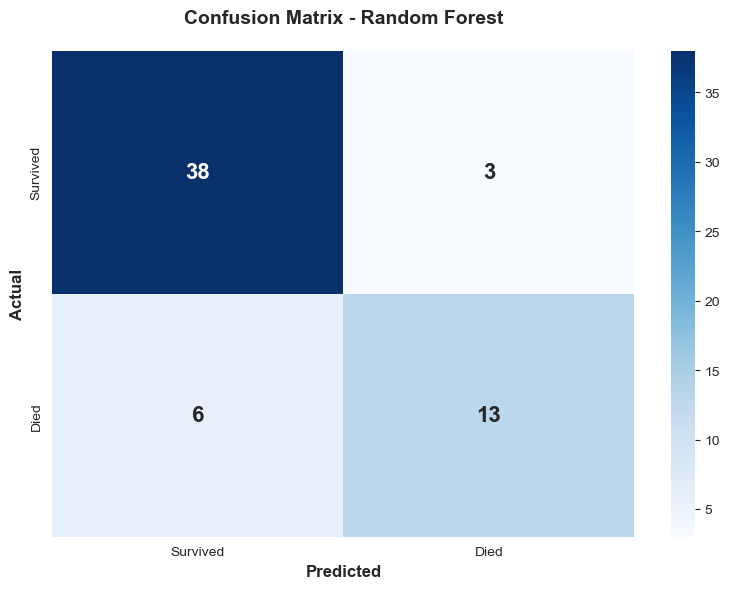

In [11]:
# Visualizations for Random Forest
plot_confusion_matrix(rf_results['confusion_matrix'], "Random Forest")


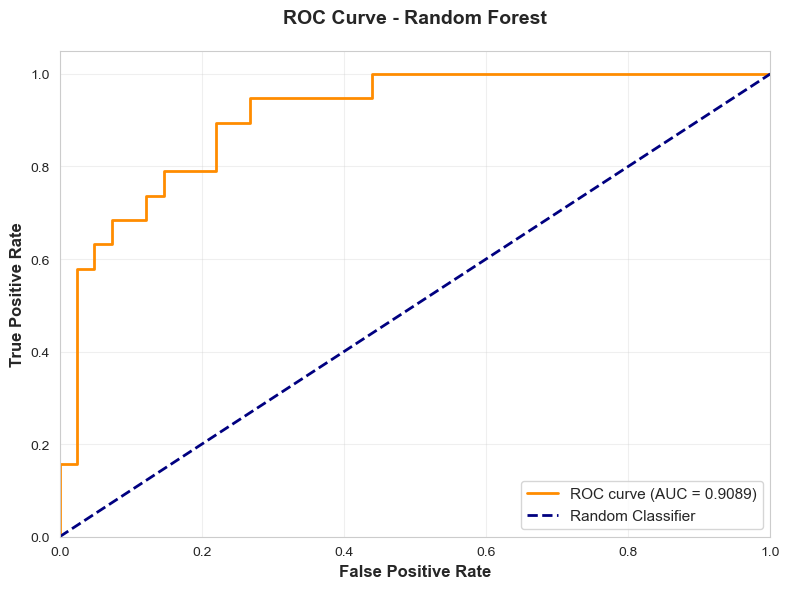

In [12]:
plot_roc_curve(y_test, rf_results['y_test_proba'], "Random Forest")


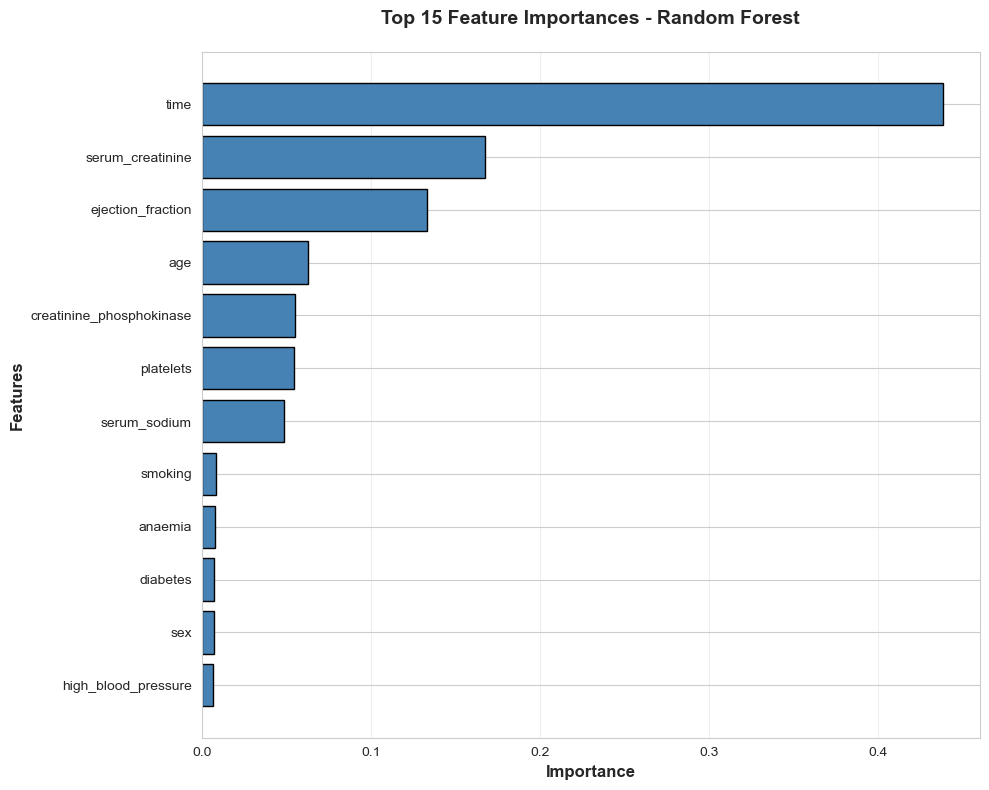


Top 10 Most Important Features:
                     feature  importance
11                      time    0.438581
7           serum_creatinine    0.167927
4          ejection_fraction    0.133529
0                        age    0.063041
2   creatinine_phosphokinase    0.055348
6                  platelets    0.054431
8               serum_sodium    0.048908
10                   smoking    0.008765
1                    anaemia    0.008068
3                   diabetes    0.007350


In [13]:
# Feature importance
rf_feature_imp = plot_feature_importance(rf_model, X.columns, "Random Forest")
print("\nTop 10 Most Important Features:")
print(rf_feature_imp.head(10))


In [14]:
print("MODEL 3: XGBOOST (WITH HYPERPARAMETER TUNING)")

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [1, 2]
}

# Initialize XGBoost
xgb_base = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# GridSearchCV with cross-validation
print("\nStarting GridSearchCV")
print(f"Testing {len(xgb_param_grid['n_estimators']) * len(xgb_param_grid['max_depth']) * len(xgb_param_grid['learning_rate']) * len(xgb_param_grid['subsample']) * len(xgb_param_grid['colsample_bytree']) * len(xgb_param_grid['gamma']) * len(xgb_param_grid['scale_pos_weight'])} combinations")

xgb_grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train_scaled, y_train)

print("\n GridSearchCV completed!")
print(f"\nBest parameters: {xgb_grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {xgb_grid_search.best_score_:.4f}")

# Best model
xgb_model = xgb_grid_search.best_estimator_


MODEL 3: XGBOOST (WITH HYPERPARAMETER TUNING)

Starting GridSearchCV
Testing 1458 combinations
Fitting 5 folds for each of 1458 candidates, totalling 7290 fits

 GridSearchCV completed!

Best parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.7}
Best cross-validation ROC-AUC score: 0.9286


In [15]:
# Evaluate XGBoost
xgb_results = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, 
                             y_train, y_test, "XGBoost")



XGBOOST - EVALUATION RESULTS

1. PERFORMANCE METRICS:
----------------------------------------------------------------------
Metric               Training             Test                
----------------------------------------------------------------------
ACCURACY             1.0000               0.8500              
PRECISION            1.0000               0.8571              
RECALL               1.0000               0.6316              
F1                   1.0000               0.7273              
ROC_AUC              1.0000               0.8485              
----------------------------------------------------------------------

2. CONFUSION MATRIX (Test Set):
----------------------------------------------------------------------
[[39  2]
 [ 7 12]]

True Negatives: 39
False Positives: 2
False Negatives: 7
True Positives: 12

3. CLASSIFICATION REPORT (Test Set):
----------------------------------------------------------------------
              precision    recall  f1-score  

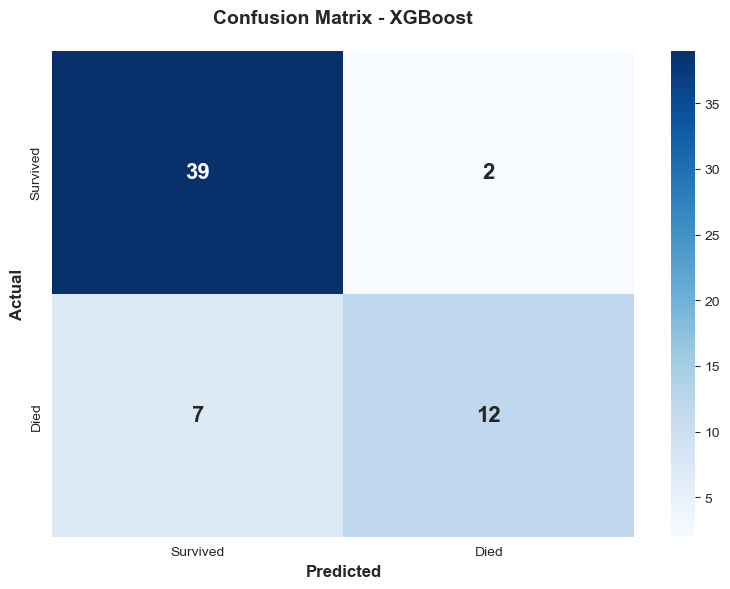

In [16]:
# Visualizations for XGBoost
plot_confusion_matrix(xgb_results['confusion_matrix'], "XGBoost")


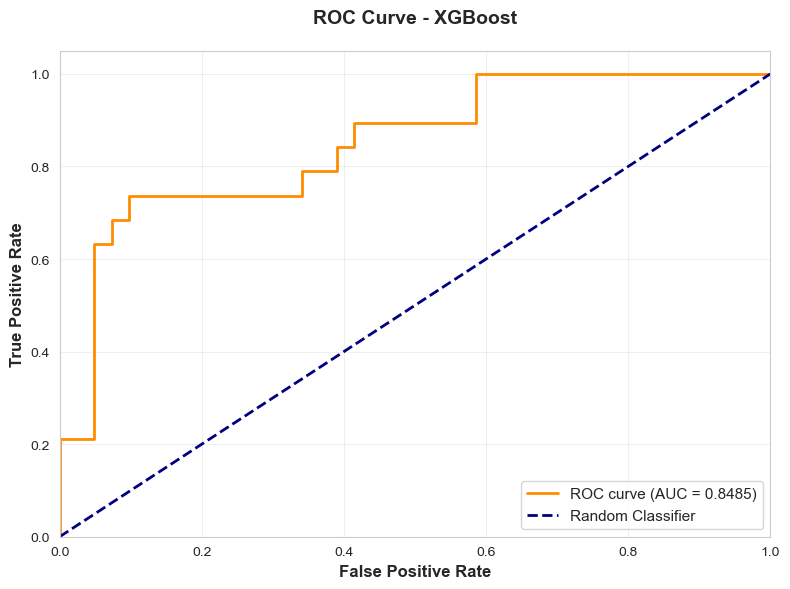

In [17]:
plot_roc_curve(y_test, xgb_results['y_test_proba'], "XGBoost")


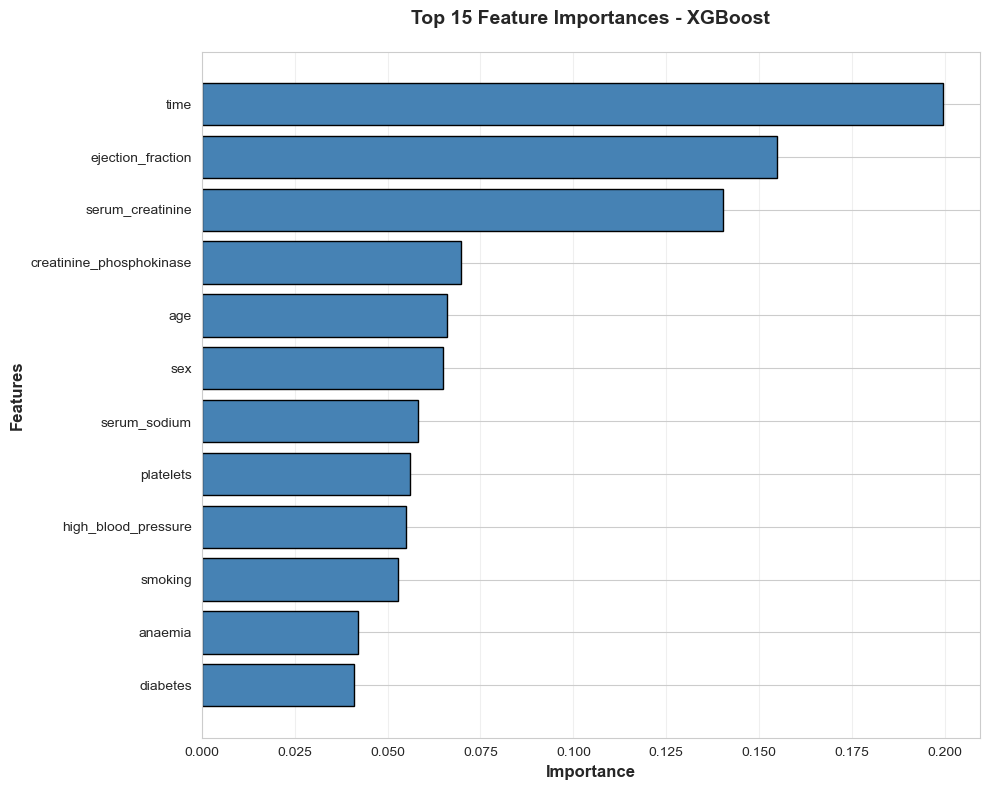


Top 10 Most Important Features:
                     feature  importance
11                      time    0.199416
4          ejection_fraction    0.154811
7           serum_creatinine    0.140215
2   creatinine_phosphokinase    0.069715
0                        age    0.066111
9                        sex    0.064808
8               serum_sodium    0.058146
6                  platelets    0.056060
5        high_blood_pressure    0.054883
10                   smoking    0.052783


In [18]:
# Feature importance
xgb_feature_imp = plot_feature_importance(xgb_model, X.columns, "XGBoost")
print("\nTop 10 Most Important Features:")
print(xgb_feature_imp.head(10))


In [ ]:
print("MODEL 4: LIGHTGBM (WITH HYPERPARAMETER TUNING)")


# Define parameter grid for LightGBM (balanced grid)
lgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 63],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8],
    'min_child_samples': [10, 20],
    'class_weight': ['balanced', None]
}

# Initialize LightGBM
lgb_base = lgb.LGBMClassifier(random_state=42, verbose=-1)

# GridSearchCV with cross-validation
print("\nStarting GridSearchCV")
print(f"Testing {len(lgb_param_grid['n_estimators']) * len(lgb_param_grid['max_depth']) * len(lgb_param_grid['learning_rate']) * len(lgb_param_grid['num_leaves']) * len(lgb_param_grid['subsample']) * len(lgb_param_grid['colsample_bytree']) * len(lgb_param_grid['min_child_samples']) * len(lgb_param_grid['class_weight'])} combinations")


lgb_grid_search = GridSearchCV(
    estimator=lgb_base,
    param_grid=lgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

lgb_grid_search.fit(X_train_scaled, y_train)

print("\n GridSearchCV completed!")
print(f"\nBest parameters: {lgb_grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {lgb_grid_search.best_score_:.4f}")

# Best model
lgb_model = lgb_grid_search.best_estimator_


MODEL 4: LIGHTGBM (WITH HYPERPARAMETER TUNING)

Starting GridSearchCV
Testing 128 combinations
Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
# Evaluate LightGBM
lgb_results = evaluate_model(lgb_model, X_train_scaled, X_test_scaled, 
                             y_train, y_test, "LightGBM")


In [ ]:
# Visualizations for LightGBM
plot_confusion_matrix(lgb_results['confusion_matrix'], "LightGBM")


In [ ]:
plot_roc_curve(y_test, lgb_results['y_test_proba'], "LightGBM")


In [ ]:
# Feature importance
lgb_feature_imp = plot_feature_importance(lgb_model, X.columns, "LightGBM")
print("\nTop 10 Most Important Features:")
print(lgb_feature_imp.head(10))


In [ ]:
# Compile all results
all_results = [lr_results, rf_results, xgb_results, lgb_results]

# Create comparison DataFrame
comparison_data = []
for result in all_results:
    comparison_data.append({
        'Model': result['model_name'],
        'Train Accuracy': result['train_metrics']['accuracy'],
        'Test Accuracy': result['test_metrics']['accuracy'],
        'Train Precision': result['train_metrics']['precision'],
        'Test Precision': result['test_metrics']['precision'],
        'Train Recall': result['train_metrics']['recall'],
        'Test Recall': result['test_metrics']['recall'],
        'Train F1': result['train_metrics']['f1'],
        'Test F1': result['test_metrics']['f1'],
        'Train ROC-AUC': result['train_metrics']['roc_auc'],
        'Test ROC-AUC': result['test_metrics']['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("MODEL COMPARISON - ALL METRICS")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    train_col = f'Train {metric}'
    test_col = f'Test {metric}'
    
    x = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison_df[train_col], width, 
                   label='Training', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, comparison_df[test_col], width, 
                   label='Test', alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


In [ ]:
# ROC curves comparison
plt.figure(figsize=(10, 8))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
models = [lr_model, rf_model, xgb_model, lgb_model]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']

for idx, (model, name, color) in enumerate(zip(models, model_names, colors)):
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Identify and Save Best Model


In [ ]:
# Find best model based on Test ROC-AUC
best_idx = comparison_df['Test ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_model_auc = comparison_df.loc[best_idx, 'Test ROC-AUC']

# Get the best model object
model_map = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model
}

best_model = model_map[best_model_name]

print("\n" + "="*70)
print("BEST MODEL SELECTION")
print("="*70)
print(f"\nBest Model: {best_model_name}")
print(f"Test ROC-AUC Score: {best_model_auc:.4f}")
print(f"\nFull metrics for best model:")
print("-" * 70)
best_row = comparison_df.iloc[best_idx]
for col in comparison_df.columns:
    if col != 'Model':
        print(f"{col}: {best_row[col]:.4f}")
print("="*70)


In [ ]:
# Save the best model
os.makedirs('models', exist_ok=True)

# Save model with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"models/best_model_{best_model_name.replace(' ', '_').lower()}_{timestamp}.pkl"
best_model_filename = 'models/best_model.pkl'

# Save both timestamped and latest version
joblib.dump(best_model, model_filename)
joblib.dump(best_model, best_model_filename)

print(f"\n✓ Best model saved successfully!")
print(f"\nSaved locations:")
print(f"  - {model_filename}")
print(f"  - {best_model_filename}")
print(f"\nModel file size: {os.path.getsize(best_model_filename)} bytes")


In [ ]:
# Save ALL trained models for future use
print("\n" + "="*70)
print("SAVING ALL MODELS")
print("="*70)

# Create models directory
os.makedirs('models', exist_ok=True)

# Save all 4 models individually
all_models = {
    'logistic_regression': lr_model,
    'random_forest': rf_model,
    'xgboost': xgb_model,
    'lightgbm': lgb_model
}

print("\nSaving individual models...")
for model_name, model_obj in all_models.items():
    filename = f'models/{model_name}_model.pkl'
    joblib.dump(model_obj, filename)
    print(f"✓ Saved {model_name} to {filename}")

print("\n✓ All 4 models saved successfully!")


In [ ]:
# Save comparison results
comparison_df.to_csv('models/model_comparison.csv', index=False)
print("\n Model comparison results saved to: models/model_comparison.csv")


In [ ]:
import joblib
import os

# Check the file exists and is valid
model_path = 'models/best_model.pkl'

if os.path.exists(model_path):
    print(f"✓ File exists: {model_path}")
    print(f"  Size: {os.path.getsize(model_path):,} bytes")
    
    # Try loading it
    model = joblib.load(model_path)
    print(f"✓ Model loaded successfully!")
    print(f"  Type: {type(model).__name__}")
    print(f"  Has predict_proba: {hasattr(model, 'predict_proba')}")
else:
    print(f"✗ File not found: {model_path}")